In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [25]:
#safe learning  
l = 5.
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

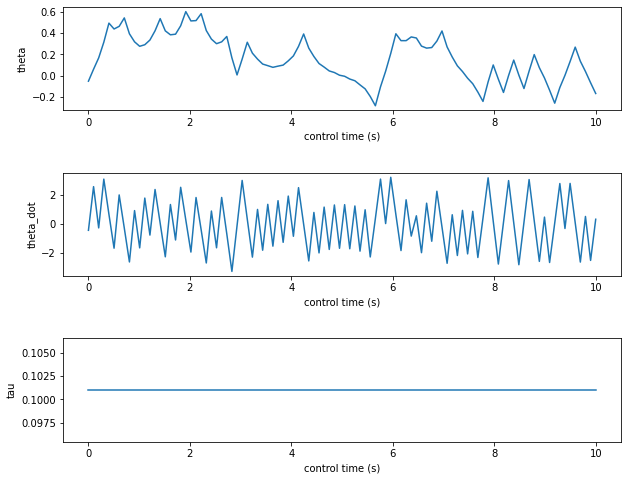

In [32]:
# environment test

# load policy
lam = '05'
num = '1'

a.actor.load_weights(f'../saved_agent/self_trigger_{lam}_{num}.h5')
# a.actor.load_weights(f'../saved_agent/self_trigger.h5') # initial policy

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

env.reset()
reward = 0
time = 0

states = []
x_axis = []
taus = []
while True:
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    x_axis.append(time)
    a_agent, tau = a.forward(x)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    time += tau
    taus.append(tau)
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
    if time > 10.:
        break
states = np.array(states)

plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('theta')
plt.plot(x_axis, states[:,0])
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('theta_dot')
plt.plot(x_axis, states[:,1])
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('tau')
plt.plot(x_axis, taus)
plt.show()